In [2]:
from scanpatterns import create_model, test_cell

In [10]:
from copy import copy, deepcopy

In [13]:
g =  hs.model.components1D.Gaussian()

In [20]:
g

<Gaussian (Gaussian component)>

In [23]:
#copy(m)
#deepcopy(m)

g =  hs.model.components1D.Gaussian()
g.deepcopy()


AttributeError: 'Gaussian' object has no attribute 'deepcopy'

In [33]:
m.append(g)

In [36]:
g.model

<Model1D>

In [40]:
copy(m)[0] is m[0]

True

In [26]:
p = g.parameters[0]

In [29]:
deepcopy(p)

<Parameter A of Gaussian component>

In [31]:
p.deepcopy()

AttributeError: 'Parameter' object has no attribute 'deepcopy'

In [12]:
import hyperspy.api as hs
s = hs.signals.Signal1D([1,2,3])

deepcopy(s)

m = s.create_model()
m.
deepcopy(m)


KeyError: '__deepcopy__'

<Model1D>

In [3]:
test_cell()

<function scanpatterns.test_cell()>

In [ ]:
create_model()

In [1]:
%matplotlib qt
import hyperspy.api as hs
Signal2D = hs.signals.Signal2D
Gaussian2D = hs.model.components2D.Gaussian2D

from ase.cluster.cubic import FaceCenteredCubic
from itertools import permutations
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import AffineTransform, warp
from transforms import correlation, translate


<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [350]:
def create_model(cell, extra_space=0, pbc=True, pixel_size: "Å" =0.1):
    XLEN, YLEN = ((cell.cell.diagonal()[:2] + 2*extra_space) // pixel_size).astype(int)
    ax0 = {
        'name':'y',
        'size': YLEN,
        'offset':-extra_space,
        'scale':pixel_size, 
        'units':'Å',
    }
    ax1 = {
        'name':'x', 
        'size': XLEN, 
        'offset':-extra_space,
        'scale':pixel_size, 
        'units':'Å',
    }

    axes = [ax0, ax1]
    s = Signal2D(np.zeros((YLEN, XLEN)), axes=axes)

    m = s.create_model()


    if pbc:
        a = [-1, 0, 1]
        merge = [list(zip(x,a)) for x in permutations(a,len(a))]
        l = []
        for entry in merge:
            l += entry
        shifts = set(l)
    else:
        shifts = [0]

    cell_center = np.array([(ax.high_value + ax.scale + ax.low_value)/2 for ax in s.axes_manager.signal_axes])
    diagonal_radius = np.array([ax.high_value for ax in s.axes_manager.signal_axes])
    
    sigma = 0.4
    for atom in cell:
        for offset in shifts:
            xyposition = atom.position[:2] + cell.cell.diagonal()[:2] * offset
            if np.abs(np.linalg.norm(xyposition - cell_center)) > np.linalg.norm(cell_center - diagonal_radius) + 1:
                continue
            A = atom.number**2
            x, y = xyposition
            g = Gaussian2D(A, sigma, sigma, x, y )
            m.append(g)
    return m

def rotation_matrix(deg):
    c = np.cos(np.deg2rad(deg))
    s = np.sin(np.deg2rad(deg))
    return np.array([[c, -s],[s, c]])
    
def rotate_model(m, angle=90):
    center = cell.cell.diagonal()[:2] / 2
    cx, cy = center

    for comp in m:
        comp_center = [comp.centre_x.value, comp.centre_y.value]
        comp.centre_x.value, comp.centre_y.value = rotation_matrix(angle) @ (comp_center - center) + center
    return m

In [351]:
surfaces = [(1, 0, 0), (1, 1, 0), (1, 1, 1)]
layers = [3, 4, 5]
lc = 3.61000
cell = FaceCenteredCubic('Cu', surfaces, layers, latticeconstant=lc)
cell[46].number = 50

m = create_model(cell, extra_space=2, pbc=False)
s2 = m.as_signal()

angle = 90

m2 = rotate_model(m, angle)
s3 = m2.as_signal()

In [352]:
s3.plot()

In [239]:
Expression = hs.model.components2D.Expression

class TopHat2D(Expression):
    def __init__(self, A=1., x0=-1., xf=1., y0=-1., yf=1, module="numpy", **kwargs):
        super(TopHat2D, self).__init__(
            expression='where((x >= x0) & (x < xf) & (y >= y0) & (y < yf), A, 0)',
            name="TopHat2D",
            A=A,
            x0=x0,
            xf=xf,
            y0=y0,
            yf=yf,
            module=module,
            autodoc=False,
            **kwargs)

        self.isbackground = False
        self.convolved = True

In [308]:
s = Signal2D(np.zeros((100, 100)))
m = s.create_model()
m.append(TopHat2D(10, 10, 90, 10, 90))
m.append(TopHat2D(-10, 20, 80, 20, 80))

#m.append(TopHat2D(10, 10, 13, 10, 13))
#m.append(TopHat2D(20, 87, 90, 87, 90))
#m.append(TopHat2D(30, 10, 13, 87, 90))


c:\users\thomasaar\documents\github\hyperspy\hyperspy\_components\expression.py:291: UserWarning: The gradients can not be computed with sympy.
  warnings.warn("The gradients can not be computed with sympy.",


In [334]:
s = drift_image(m, [0,0])
vec = [1, 0]
rad = np.angle(vec[0] + vec[1]*1j)
print("Theta:", np.rad2deg(rad))

grad = 250
drift_vector = np.array(vec)/grad
s1 = drift_image(m, drift_vector)

Theta: 0.0


In [335]:
np.rad2deg(np.arctan(s.data.shape[1] / grad))

21.80140948635181

In [338]:
%matplotlib qt

In [348]:
s1.plot()
1

1

In [340]:
xi, yi = 14.5, 9.5
xf, yf = 45.5, 89.5

In [342]:
dx = xf - xi
dy = yf - yi

In [344]:
dy

80.0

In [347]:
np.rad2deg(np.arctan(31/80))

21.181349500266236

In [315]:
s1

<Signal2D, title: , dimensions: (|100, 100)>

In [167]:
drift_vector = np.array([1,0])/5000
image_angles = np.array([0, 90])

drift_vectors = [rotation_matrix(angle) @ drift_vector for angle in image_angles]

In [250]:
def probe_positions(m, drift_vector, scale=None, scannoise=True, xlen=None, ylen=None, start: "(x,y)"=None):
    if xlen == None or ylen == None:
        xlen, ylen = m.axes_manager.signal_shape
    if scale == None:
        scale = m.axes_manager[-1].scale
    if start == None:
        start = [ax.offset for ax in m.axes_manager.signal_axes]
    X = np.zeros((ylen, xlen))
    Y = np.zeros((ylen, xlen))
    
    xdrift = 0
    ydrift = 0

    if scannoise == True:
        xnoise = np.random.random() * 0.1
    elif scannoise == False:
        xnoise = 0
    else:
        xnoise = scannoise
    
    for yi in range(ylen):
        xnoise = np.random.random() * 0.1 # flyback noise

        for xi in range(xlen):
            xdrift -= drift_vector[0]
            ydrift -= drift_vector[1]

            X[yi, xi] = xi*scale + start[0] + xdrift*scale + xnoise
            Y[yi, xi] = yi*scale + start[1] + ydrift*scale
    return X, Y

def intensity_nd(m, X, Y):
    intensity = np.zeros(X.shape)
    for comp in m:
        if comp.active:
            intensity += comp.function_nd(X, Y)
    return intensity

def image_from_probe_positions(m, XY):
    I = intensity_nd(m, *XY)
    try:
        return m.signal._deepcopy_with_new_data(I)
    except:
        return m._deepcopy_with_new_data(I)

def drift_image(m, drift_vector, scale=None):
    XY = probe_positions(m=m, drift_vector=drift_vector, scale=scale)
    s = image_from_probe_positions(m, XY)
    return s

In [6]:
from ase.lattice.cubic import FaceCenteredCubic
atoms = FaceCenteredCubic(directions=[[1,-1,0], [1,1,-2], [1,1,1]],
                          size=(5,3,1), symbol='Cu', pbc=(1,1,1))
atoms[63].number = 50
atoms[69].number = 50
cell = atoms

In [31]:
# surfaces = [(1, 0, 0), (1, 1, 0), (1, 1, 1)]
# layers = [3, 4, 5]
# lc = 3.61000
# cell = FaceCenteredCubic('Cu', surfaces, layers, latticeconstant=lc)
# cell[46].number = 50

m = create_model(cell, extra_space=2, pbc=False, pixel_size=0.05)
s = m.as_signal()

angle = 0
drift_direction = [0, 1]
drift_vector = rotation_matrix(angle) @ drift_direction / 1000
s1 = drift_image(m, drift_vector)

angle = 90
rotate_model(m, angle)
drift_vector = rotation_matrix(angle) @ drift_direction / 1000
s2 = drift_image(m, drift_vector)

In [32]:
%matplotlib qt

In [276]:
shear_limits = 0.8
shear_step = 0.01
scale_limits = 0.8
scale_step = 0.01

In [279]:
import ipywidgets.widgets as w
SCALE = w.FloatSlider(value=1, min=-scale_limits + 1, max=scale_limits + 1, step=shear_step, description='Scale')
SHEAR = w.FloatSlider(value=0, min=-shear_limits, max=shear_limits, step=scale_step, description='Shear')
img = s2.data

o = w.Output()
def warpit(img):
    angle = 0
    rot_matrix = AffineTransform(rotation = np.deg2rad(-angle))
    shear_matrix = AffineTransform(shear = SHEAR.value,)
    scale_matrix = AffineTransform(scale = (1, SCALE.value))

    shift_x, shift_y = np.array(img.shape) / 2.0
    tf_shift = AffineTransform(translation=[-shift_y, -shift_x])
    tf_shift_inv = AffineTransform(translation=[shift_y, shift_x])
    warped = warp(img,(tf_shift + shear_matrix + scale_matrix + rot_matrix + tf_shift_inv).inverse, order=0,)
    return warped

fig, (ax1, ax2) = plt.subplots(ncols=2)

ax1.imshow(s.data)
im = ax2.imshow(warpit(img))

def on_value_change(change):
    with o:
        new_img = warpit(img)
        im.set_data(new_img)
        im.autoscale()

SCALE.observe(on_value_change, names='value')
SHEAR.observe(on_value_change, names='value')
display(SCALE)
display(SHEAR)
display(o)

FloatSlider(value=1.0, description='Scale', max=1.8, min=0.19999999999999996, step=0.01)

FloatSlider(value=0.0, description='Shear', max=0.8, min=-0.8, step=0.01)

Output()

In [282]:
%matplotlib inline

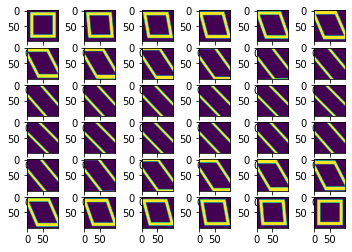

In [289]:
nrows = 6
ncols = 6
img = s.data
shift_x, shift_y = np.array(img.shape) / 2.0
tf_shift = AffineTransform(translation=[-shift_y, -shift_x])
tf_shift_inv = AffineTransform(translation=[shift_y, shift_x])
fig, AX = plt.subplots(ncols=ncols, nrows=nrows, )
for shear, ax in zip(np.linspace(0, np.pi, np.prod((ncols, nrows))), AX.flatten()):
    ax.imshow(warp(s.data, tf_shift + AffineTransform(shear=shear) + tf_shift_inv))

In [ ]:
0.36, -0.35


In [ ]:
1, 0.33
0.7, 1

In [ ]:
#drift_direction = [1, 0]
#1, 0.18
#0.81, 0

In [ ]:
#drift_direction = [1, 1]
#0.84, 0.19
#0.84, -0.19

In [185]:
SCALE

FloatSlider(value=1.0, description='Scale', max=1.033783783783784, min=0.966216216216216, step=0.0056306306306…

In [173]:
w = warpit(s1.data)

In [177]:
%matplotlib widget

In [180]:
plt.figure()
im = plt.imshow(s1.data)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

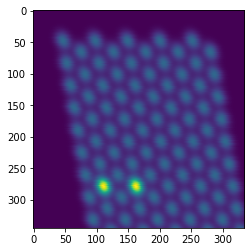

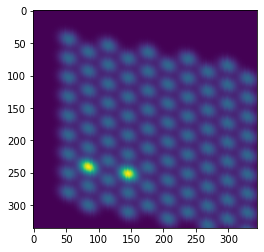

In [170]:
plt.figure()
plt.imshow(s1.data)
plt.figure()
plt.imshow(np.rot90(s2.data))

In [27]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.max_open_warning'] = 2000
import hyperspy.api as hs

import time
from pathlib import Path
import h5py
import logging

from scipy.ndimage import fourier_shift
from numpy.fft import fft2

start_time = time.time()

from transforms import (
    prepare_correlation_data,
    correlate_images,
    correlation,
    translate,
    pad_images,
    set_shear_and_scale_ranges,
    set_transform_matrices,
    transform,
    transform_single_image,
    plot_transformed_images,
    normalise_max,
)

pad_factor = 1.3  # larger than 1, approx 1.25 is good
steps = 11  # odd, 5,7 is normal
correlation_method = "cross"  # "phase", "cross", "hybrid"
gpu = False  # True / False
shear_steps = steps
scale_steps = steps


In [62]:
angles = (0, -90)
images = [s1.data, s2.data]

In [66]:
from transforms import set_transform_matrices

In [79]:
pix = 2
image_shape = images[0].shape
scale = (image_shape[1] + pix) / image_shape[1] - 1
# Shear by an angle equivalent of shearing `pix` pixels

half_steps = (scale_steps - 1) / 2
scale_limits = scale * half_steps
scales = 1 + np.linspace(-scale_limits, scale_limits, scale_steps)

half_steps = (shear_steps - 1) / 2
shear = np.arctan(pix / image_shape[1])  # maybe scale[0]?
shear_limits = shear * half_steps
sheares = np.linspace(-shear_limits, shear_limits, shear_steps)
    

In [81]:
np.linspace(-scale_limits, scale_limits, scale_steps) + 1

array([0.96621622, 0.97297297, 0.97972973, 0.98648649, 0.99324324,
       1.        , 1.00675676, 1.01351351, 1.02027027, 1.02702703,
       1.03378378])

In [111]:
import ipywidgets.widgets as w
SCALE = w.FloatSlider(value=1, min=-scale_limits + 1, max=scale_limits + 1, step=2*scale_limits/12, description='Scale')
SHEAR = w.FloatSlider(value=1, min=-shear_limits, max=shear_limits, step=2*shear_limits/12, description='Shear')

In [114]:
def onchange():
    AffineTransform(rotation=np.deg2rad(angle), shear=SHEAR.value, scale=(1, SCALE.value))
    

In [127]:
from skimage.transform import AffineTransform, warp



In [132]:
img = images[1]

def warpit(img):
    rot_matrix = AffineTransform(rotation = np.deg2rad(-angle))
    shear_matrix = AffineTransform(shear = SHEAR.value,)
    scale_matrix = AffineTransform(scale = (1, SCALE.value))

    shift_x, shift_y = np.array(img.shape) / 2.0
    tf_shift = AffineTransform(translation=[-shift_y, -shift_x])
    tf_shift_inv = AffineTransform(translation=[shift_y, shift_x])
    warped = warp(img,(tf_shift + scale_matrix + shear_matrix + rot_matrix + tf_shift_inv).inverse, order=0,)
    return warped

array([[4.95754068e-38, 9.05791350e-38, 8.44747557e-37, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.50474127e-37, 2.77156866e-37, 2.54650577e-36, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.49639792e-37, 8.34892340e-37, 7.55735365e-36, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.34826696e-18, 1.97729134e-18, 3.65974294e-18],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.30337379e-18, 7.69683828e-19, 1.45283506e-18],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        5.00218696e-19, 2.95197783e-19, 5.67917937e-19]])

In [136]:
plt.figure()
plt.imshow(warpit(img))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [95]:
images[1].shape

(296, 296)

In [93]:
trans

<AffineTransform(matrix=
    [[ 6.12323400e-17, -5.40302306e-01,  0.00000000e+00],
     [ 1.00000000e+00, -8.41470985e-01,  0.00000000e+00],
     [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]) at 0x18293844c10>

In [92]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(images[0])
ax2.imshow(trans @ images[1])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

ValueError: matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

In [63]:
images = [normalise_max(img) for img in images]
print("Padding images")
padded_images, weights = pad_images(images, pad_factor=pad_factor)
GB = np.round(
    float(np.prod(np.shape(padded_images)))
    * shear_steps
    * scale_steps
    * padded_images[0].dtype.itemsize
    / 1e9,
    2,
)  # 32 bytes per complex64

print("Estimating memory usage of {}GB".format(GB))
# Set the various sheares, scales, first in terms of range
sheares, scales = set_shear_and_scale_ranges(
    padded_images[0].shape, shear_steps=shear_steps, scale_steps=scale_steps, pix=2
)
# Then in terms of transform matrices
print("Calculating transform matrices")
transform_matrices = set_transform_matrices(angles, sheares, scales)

rotation_matrices, shear_matrices, scale_matrices = transform_matrices

# Scale and shear the masked data
print("Transforming data")
t = time.time()
data = transform(
    padded_images, rotation_matrices, shear_matrices, scale_matrices, weights=weights
)
print('It took {} sec'.format(round(time.time() - t)))
data = data.astype("float32")

data = data.reshape((len(padded_images), -1) + padded_images[0].shape)
data = data.swapaxes(0, 1)

print("Preparing correlation data")
correlation_data = prepare_correlation_data(
    data, weights, method=correlation_method, gpu=gpu
)

print("Correlating")
max_indexes, shifts_list = correlate_images(
    correlation_data, method=correlation_method, gpu=gpu
)
# Plot masked images
print("Calculating final images")
data2 = np.array(data).swapaxes(0, 1)
image_sums = []

for i, img_array in enumerate(data2[1:]):
    max_index = int(max_indexes[i])
    img1 = data2[0, max_index]
    img2 = img_array[max_index]
    shift = shifts_list[i][max_index]
    img2_shifted = np.fft.ifftn(fourier_shift(fft2(img2), shift)).real
    image_sums.append(img1 + img2_shifted)
    print("Image drifted ({}, {}) pixels since first frame".format(shift[0], shift[1]))
# fig, AX = plt.subplots(ncols=len(padded_images) - 1, squeeze=False)
# for i, ax in enumerate(np.reshape(AX, np.prod(AX.shape))):
#     ax.imshow(image_sums[i], cmap="viridis")
#     ax.axis("off")

i1, i2 = plot_transformed_images(
    padded_images,
    angles,
    shifts_list,
    max_indexes,
    sheares,
    scales,
    shear_steps,
    scale_steps,
)


Padding images
Estimating memory usage of 0.29GB
Calculating transform matrices
Transforming data
It took 1 sec
Preparing correlation data
Correlating



Calculating final images
Image drifted (-1.0, -1.0) pixels since first frame


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [64]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(correlation_data[0,0])
ax2.imshow(correlation_data[0,1])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [42]:
plt.figure()
plt.imshow(img1)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [40]:
plt.figure()
plt.imshow(img2_shifted)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [143]:
import scipy.ndimage
I2 = s2.data.copy()
xlen, ylen = I2.shape
ds = []
shifts = []
for y_index in np.arange(1, ylen):
    I_backup = I2[y_index].copy()
    y_start = y_index - 5 if y_index - 5 > 0 else 0
    y_end = y_index + 5
    d = []
    mxshift = 15
    shift_array = np.arange(-mxshift, mxshift, 1)
    for shift in shift_array:
        I2[y_index] = scipy.ndimage.shift(I_backup, shift, mode='wrap')
        diff1 = np.abs(np.diff(I2[y_start:y_end, mxshift:-mxshift], axis=0)).mean()
        diff = diff1# + diff2
        d.append(diff)
    ds.append(d)
    final_shift = shift_array[np.argmin(d)]
    shifts.append(final_shift)
    I2[y_index] = scipy.ndimage.shift(I_backup, final_shift, mode='wrap')
ds = np.array(ds)

In [144]:
plt.figure()
for d in ds:
    d = d - d.min()
    d = d / d.max()
    plt.plot(d)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [146]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize= (16, 8))
ax1.imshow(s2.data)
ax2.imshow(I2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [147]:
np.abs(np.diff(s2.data)).sum()

1028202.8203378455

In [148]:
np.abs(np.diff(I2.data)).sum()

1030695.6852503372

In [149]:
np.abs(np.diff(s.data)).sum()

12960139.188392874

In [58]:
m = create_model(cell, extra_space=2, pbc=False, pixel_size=0.01)
s = m.as_signal()

angle = 0
drift_direction = [0, 1]
drift_vector = rotation_matrix(angle) @ drift_direction / 500000
s1 = drift_image(m, drift_vector)
s1.plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …